In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install keras_vggface
!pip install keras_applications
!pip install PyYAML

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 4.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from PIL import Image
#from keras_vggface.utils import preprocess_input
#from keras.utils.layer_utils import get_source_inputs
from keras_vggface.vggface import VGGFace
import numpy as np
import cv2
import os
from scipy import spatial
import tensorflow as tf


In [ ]:
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
import csv
import pandas as pd
import keras

In [ ]:
BASE_MODEL = 'vgg16'
include_top = 'False'
pooling = 'avg'

model=VGGFace(model=BASE_MODEL,include_top=include_top,weights='vggface',input_shape=(224,224,3),pooling=pooling)
print(model)

580083712/580070376 [==============================] - 19s 0us/step


In [ ]:
os.mkdir('reference')
os.mkdir('faces')
os.mkdir('faces_on_original_image')

In [ ]:
import cv2
import sys

def mtcnn(file_path,reference=False):
  image = cv2.imread(file_path)
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
  faces = faceCascade.detectMultiScale(gray,scaleFactor=1.3,minNeighbors=3,minSize=(30, 30) )
  print("[INFO] Found {0} Faces.".format(len(faces)))
  dir='/content/faces'
  for f in os.listdir(dir):
    if not(f=='.ipynb_checkpoints'):
      os.remove(os.path.join(dir, f))
  if reference == True:
    (x,y,w,h)=faces[0]
    roi_color = image[y:y + h, x:x + w]
    path='/content/reference/face_of_the_person.jpg'
    cv2.imwrite(path, roi_color)
    print("file saved at",path)
  else:
    i=1
    
    for (x, y, w, h) in faces:
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        roi_color = image[y:y + h, x:x + w]
        print("[INFO] Object found. Saving locally.")
        cv2.imwrite('/content/faces/detected_faces'+str(i)+'.jpg', roi_color)
        i=i+1

  status = cv2.imwrite('/content/faces_on_original_image/faces_detected.jpg', image)
  print("[INFO] Image faces_detected.jpg written to filesystem: ", status)

In [ ]:
def get_image_embedding(saving_dir):
  img=Image.open(saving_dir)
  img=img.resize((224,224))
  img_array=np.array(img).astype(np.float32)
  #img_array = img_array.transpose((2,0,1))
  expanded_img=np.expand_dims(img_array,axis=0)
  result=model.predict(expanded_img)
  return result.flatten()

In [ ]:
def triplet_loss(e1,e2):
  #finds the difference between features of the each image
  distance=np.subtract(e1,e2)
  #the loss is squared so that non similar values stay more apart
  loss=np.square(distance) 
  return loss


Fully connected layers to predict similarity


In [ ]:
df =pd.read_csv('/content/drive/MyDrive/dlsip_and_maths/mtcnned/studentfile.csv')
df = df.iloc[: , 1:]
X = df.drop(['Target'],axis=1).values   # independant features
y = df['Target'].values		

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5)

In [ ]:
df.shape

(6394, 2623)

In [ ]:
X_train.shape

(5115, 2622)

In [ ]:
y_train

array([0, 0, 0, ..., 0, 0, 1])

In [ ]:

model_fnn = Sequential([Dense(3000, activation='relu', input_shape=(2622,)),
  Dense(4000, activation='relu'),
  Dense(4000, activation='relu'),
  Dense(1, activation='sigmoid'),])



In [ ]:
model_fnn.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy'])

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

In [ ]:
hist = model_fnn.fit(X_train, y_train,
        batch_size=32, epochs=150,
        validation_data=(X_test, y_test))


Epoch 1/150
160/160 [==============================] - 5s 12ms/step - loss: 0.5691 - accuracy: 0.7089 - val_loss: 0.6078 - val_accuracy: 0.6672
Epoch 2/150
160/160 [==============================] - 2s 10ms/step - loss: 0.5497 - accuracy: 0.7138 - val_loss: 0.6112 - val_accuracy: 0.6672
Epoch 3/150
160/160 [==============================] - 2s 10ms/step - loss: 0.5320 - accuracy: 0.7286 - val_loss: 0.5542 - val_accuracy: 0.7016
Epoch 4/150
160/160 [==============================] - 2s 11ms/step - loss: 0.5049 - accuracy: 0.7458 - val_loss: 0.5391 - val_accuracy: 0.7094
Epoch 5/150
160/160 [==============================] - 2s 10ms/step - loss: 0.4891 - accuracy: 0.7486 - val_loss: 0.5217 - val_accuracy: 0.7297
Epoch 6/150
160/160 [==============================] - 2s 10ms/step - loss: 0.4612 - accuracy: 0.7674 - val_loss: 0.5044 - val_accuracy: 0.7312
Epoch 7/150
160/160 [==============================] - 2s 10ms/step - loss: 0.4354 - accuracy: 0.7867 - val_loss: 0.4614 - val_accuracy:

In [ ]:
model_fnn.evaluate(X_test, y_test)[1]

20/20 [==============================] - 0s 3ms/step - loss: 0.4148 - accuracy: 0.9156


0.9156249761581421

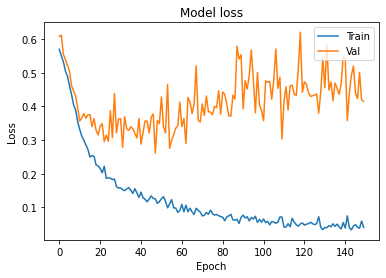

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

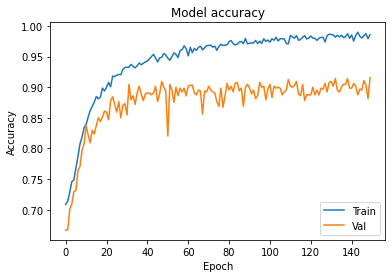

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [ ]:
def maincode():
  #imagePath='/content/drive/MyDrive/dlsip_and_maths/references/1.jpg'
  print("give student number1-6 :")
  pno= input()
  imagePath='/content/drive/MyDrive/dlsip_and_maths/reference_persons/'+str(pno)+'.jpg'
  print(imagePath)

  mtcnn(imagePath,reference=True)
  saving_dir='/content/reference/face_of_the_person.jpg'


  #select the folder of images
  print("enter folder number (1-6): ")
  fno= input()
  path_of_the_directory='/content/drive/MyDrive/dlsip_and_maths/uncropped/person'+str(fno)
  folder_output=[]
  referenceorg=get_image_embedding(saving_dir)
  features=['f'+str(i) for i in range(2622)]
  for filename in os.listdir(path_of_the_directory):
    file=os.path.join(path_of_the_directory,filename)
    if os.path.isfile(file):
      mtcnn(file,reference=False)
    all_similirity_scores=[]
    for im in os.listdir('/content/faces'):
      j=os.path.join('/content/faces',im)
      if os.path.isfile(j):
        embb=get_image_embedding(j)
        dist=triplet_loss(referenceorg,embb)
        inp=pd.DataFrame([dist], columns=features)
        score=model_fnn.predict(inp)
        all_similirity_scores.append(score)
    
    folder_output.append([filename,max(all_similirity_scores)])
    
    print(all_similirity_scores)
  return folder_output

In [ ]:
while(1):
  print(maincode())
  if not(int(input('enter 0 to quit'))):
    break



give student number1-6 :
1
/content/drive/MyDrive/dlsip_and_maths/reference_persons/1.jpg
[INFO] Found 1 Faces.
file saved at /content/reference/face_of_the_person.jpg
[INFO] Image faces_detected.jpg written to filesystem:  True
enter folder number (1-6): 
1
[INFO] Found 6 Faces.
[INFO] Object found. Saving locally.
[INFO] Object found. Saving locally.
[INFO] Object found. Saving locally.
[INFO] Object found. Saving locally.
[INFO] Object found. Saving locally.
[INFO] Object found. Saving locally.
[INFO] Image faces_detected.jpg written to filesystem:  True
[array([[4.68366e-28]], dtype=float32), array([[3.8486956e-19]], dtype=float32), array([[0.99958414]], dtype=float32), array([[1.0110446e-05]], dtype=float32), array([[6.996675e-06]], dtype=float32), array([[1.384578e-08]], dtype=float32)]
[INFO] Found 7 Faces.
[INFO] Object found. Saving locally.
[INFO] Object found. Saving locally.
[INFO] Object found. Saving locally.
[INFO] Object found. Saving locally.
[INFO] Object found. Savin

In [ ]:
vec=get_image_embedding('/content/faces/detected_faces1.jpg')
print('no.of features form each image: ',len(vec))

no.of features form each image:  2622
